# Gather list of MICCAI papers
We can't distinguish papers from MICCAI using only OpenAlex, therefore we've used the API of [dblp.org](dblp.org) to get them.

We have to query an url similar to https://dblp.org/search/publ/api?q=stream%3Aconf%2Fmiccai%3A%20streamid%3Aconf%2Fmiccai%3A%20type%3AConference_and_Workshop_Papers%3A&h=1000&f=1000&format=json

We iterate through f value, as we can only get 1000 papers from a query, the f parameter indicates at which paper the result starts


## Get list of papers

In [11]:
import requests
indice_paper = 0
nextPage = True
#Dictionnary with doi as key and title as value
lst_paper = {}
while nextPage:
    request_url = f"https://dblp.org/search/publ/api?q=stream%3Aconf%2Fmiccai%3A%20streamid%3Aconf%2Fmiccai%3A%20type%3AConference_and_Workshop_Papers%3A&h=1000&f={indice_paper}&format=json"
    request = requests.get(request_url)
    if request.status_code == 200:
        r_json = request.json()
        if r_json["result"]["hits"]["@sent"] != '0':
            for paper in r_json["result"]["hits"]["hit"]:
                if "doi" not in paper["info"] or "title" not in paper["info"] or int(paper["info"]["year"]) < 2013 or paper["info"]["venue"] != "MICCAI":
                    continue
                title = paper["info"]["title"]
                title = title.replace(",","")
                title = title.replace("\n","")
                year = paper["info"]["year"]
                venue = paper["info"]["venue"]
                doi = paper["info"]["doi"]
                lst_paper[doi] = title
            indice_paper += 1000
        else:
            nextPage = False
        
            

## Save it in a csv
So we don't need to query again the API

In [1]:
import csv
with open('../../data/miccai_papers.csv','w') as f:
    f.write("doi,title")
    for k in lst_paper:
        f.write(f"\n{k},{lst_paper[k]}")

NameError: name 'lst_paper' is not defined

# Request OpenAlex
For each paper obtained above, we use its API to query OpenAlex and check if a dataset is in the references. Then we apply the wrong reference detection process

### Load list of papers and datasets

In [47]:
import requests
lst_paper = {}
reader = csv.DictReader(open('../../data/miccai_papers.csv'))
for paper in reader:
    lst_paper[paper["doi"]] = paper["title"]

#Dictionnary with dataset's name as key and DOI as value
datasets_doi = {}
ds_reader = csv.DictReader(open('../../data/datasets.csv'))
for ds in ds_reader:
    datasets_doi[ds["name"]] = ds["DOI"]

"""
Convert a DOI to OpenAlex ID used as value in some API field such as "referenced_works"
@param
    - DOI: the doi we want to convert
@return
    The OpenAlex ID if the DOI is in OpenAlex database, None otherwise
"""
def doi_to_OpenAlexId(doi):
    base_url = f"https://api.openalex.org/works/doi:{doi}"
    r = requests.get(base_url)
    if r.status_code == 200:
        r_json = r.json()
        return r_json["id"]
    else:
        return None

#Dictionnary with dataset names as key and openalex id as value. We associate an openalex ID because it's the value in the "referenced_works" field given by the API.
datasets_id = {}

#Convert DOI to OpenAlexID
for ds  in datasets_doi:
    openalex_id = doi_to_OpenAlexId(datasets_doi[ds])
    if not openalex_id:
        print(f"Couldn't convert DOI for {ds} into OpenAlex ID")
    datasets_id[ds]=openalex_id

Couldn't convert DOI for Synapse into OpenAlex ID


In [4]:
datasets_id

{'ACDC': 'https://openalex.org/W2804047627',
 'LA': 'https://openalex.org/W3093394156',
 'MSCMR': 'https://openalex.org/W4312016581',
 'M&Ms': 'https://openalex.org/W4226199676',
 'PROMISE12': 'https://openalex.org/W2106033751',
 'I2CVB': 'https://openalex.org/W2049522781',
 'BRATS': 'https://openalex.org/W1641498739',
 'Synapse': None}

### Query OpenAlex for each paper

In [54]:
from tqdm import tqdm
from collections import Counter
paper_referencing = {ds:[] for ds in datasets_id}
errors = Counter()
nb_pymed = 0
for doi in tqdm(lst_paper):
    title = lst_paper[doi]
    request_url = f"https://api.openalex.org/works/doi:{doi}"
    request = requests.get(request_url)
    if request.status_code == 200:
        r_json = request.json()
        fulltext_url = r_json["open_access"]["oa_url"]
        pmid = None
        #Remove review/survey paper
        if "review" in title.lower() or "survey" in title.lower():
            continue
        if "pmid" in r_json["ids"]:
            nb_pymed += 1
            pmid = r_json["ids"]["pmid"]
        for ds in paper_referencing:
            if datasets_id[ds] in r_json["referenced_works"]:
                paper_referencing[ds].append((title,doi,r_json["publication_year"],r_json["abstract_inverted_index"],fulltext_url,pmid))
    else:
        errors[request.status_code] += 1

100%|██████████| 3839/3839 [29:14<00:00,  2.19it/s]


In [8]:
errors

Counter({404: 1})

In [9]:
for d in paper_referencing:
    print(f"Number of citations for {d}: {len(paper_referencing[d])}")

Number of citations for ACDC: 40
Number of citations for LA: 6
Number of citations for MSCMR: 0
Number of citations for M&Ms: 8
Number of citations for PROMISE12: 19
Number of citations for I2CVB: 7
Number of citations for BRATS: 76
Number of citations for Synapse: 0


### Try pymed library

In [55]:
nb_pymed

896

In [81]:
from pymed import PubMed
pubmed = PubMed(tool="PubMedSearcher", email="theo.sourget@univ-rouen.fr")
end = False
for ds in paper_referencing:
    if end:
        break
    for paper in paper_referencing[ds]:
        if end:
            break
        paper_pmid = paper[5]
        if paper_pmid:
            article = list(pubmed.query(paper_pmid.removeprefix('https://pubmed.ncbi.nlm.nih.gov/'), max_results=1))[0]
            article_dict = article.toDict()
            if article_dict["methods"]:
                print(article_dict["methods"])
                end = True
         

In [84]:
article_dict

{'pubmed_id': '29900427\n19783500\n23766935\n25494501\n25752327\n11241813\n23498985\n20724753',
 'title': 'Liver tissue classification in patients with hepatocellular carcinoma by fusing structured and rotationally invariant context representation.',
 'abstract': 'This work addresses multi-class liver tissue classification from multi-parameter MRI in patients with hepatocellular carcinoma (HCC), and is among the first to do so. We propose a structured prediction framework to simultaneously classify parenchyma, blood vessels, viable tumor tissue, and necrosis, which overcomes limitations related to classifying these tissue classes individually and consecutively. A novel classification framework is introduced, based on the integration of multi-scale shape and appearance features to initiate the classification, which is iteratively refined by augmenting the feature space with both structured and rotationally invariant label context features. We study further the topic of rotationally inva

In [15]:
import csv
with open('./ref_miccai.csv','w') as f:
    f.write("doi,title,dataset")
    for d in paper_referencing:
        for p in paper_referencing[d]:
            f.write(f"\n{p[1]},{p[0]},{d}")

## Apply pipeline

### Abstract

In [17]:
import numpy as np
"""
Reconstruct and transform the abstract of a paper using abstract_inverted_index field. We will removed non alpha numeric caracters and lower every word.
"""
def reconstruct_abstract(paper):
    # Maximum size of the abstract, if the paper abstarct is longer it will be truncated
    abstract = np.full(2500,"",dtype=object)
    # The "abstract_inverted_index" field is a dictionnary with word as key and locations of this word in the abstract
    # So we fill the abstarct variable above at the index of the word to reconstruct the abstract
    if paper[3]:
        for w in paper[3]:
            for indices in paper[3][w]:
                if indices < 2500:
                    abstract[indices] = ''.join(filter(str.isalnum, w)).lower()
        # Remove empty location mostly due to a shorter abstract 
        abstract = abstract[abstract != ""]
        #Convert array to string
    str_abstract = ' '.join(abstract)
    return str_abstract

In [18]:
paper_using_abstract = {dataset:[] for dataset in paper_referencing}
for dataset in paper_referencing:
    for paper in paper_referencing[dataset]:
        abstract = reconstruct_abstract(paper)
        if dataset.lower() in abstract:
            paper_using_abstract[dataset].append(paper[1])

In [40]:
for d in paper_using_abstract:
    paper_using_abstract[d] = set(paper_using_abstract[d])
    print(f"Number of citations for {d}: {len(paper_using_abstract[d])}")

Number of citations for ACDC: 8
Number of citations for LA: 6
Number of citations for MSCMR: 0
Number of citations for M&Ms: 0
Number of citations for PROMISE12: 3
Number of citations for I2CVB: 0
Number of citations for BRATS: 29
Number of citations for Synapse: 0


### Download paper's fulltexts

In [23]:
import glob
downloaded_doi = []
title_to_doi = {}
#Already downloaded pdf
pdf_path = glob.glob("../../results/papers_fulltext/miccai/*.pdf")

In [24]:
from pypdf import PdfReader
from pypdf.errors import PdfReadError

for dataset in paper_referencing:
    for paper in tqdm(paper_referencing[dataset]):
        title = paper[0].replace('/','')
        doi = paper[1]
        fulltext_url = paper[4]
        file_path = f"../../results/papers_fulltext/miccai/{title}.pdf"

        if title not in title_to_doi:
            title_to_doi[title]=doi
        if not fulltext_url:
            continue
        if file_path in pdf_path:
            continue
        if not paper in paper_using_abstract[dataset]:
            #Check that paper hasn't been downloaded before (for another dataset), otherwise try to download it
            if doi not in downloaded_doi:
                try:
                    r_fulltext = requests.get(fulltext_url,allow_redirects=True,timeout=10)
                    pdf_content = r_fulltext.content
                    if r_fulltext.status_code == 200:
                        open(file_path,"wb").write(r_fulltext.content)
                        downloaded_doi.append(doi)
                    else:
                        continue
                except requests.exceptions.RequestException as ce:
                    continue
            try:
                #Try to read the pdf (Raise an error if the file is an invalid pdf)
                PdfReader(file_path,strict=True)
            except PdfReadError:
                #If a PdfReadError is raised, the pdf is invalid and therefore removed from downloaded list
                downloaded_doi.remove(doi)
                continue


100%|██████████| 6/6 [00:03<00:00,  1.50it/s]
0it [00:00, ?it/s]
100%|██████████| 76/76 [02:16<00:00,  1.80s/it]
0it [00:00, ?it/s]


In [25]:
print(f"Number of downloaded fulltext: {len(downloaded_doi)}")

Number of downloaded fulltext: 102


In [26]:
pdf_path = glob.glob("../../results/papers_fulltext/miccai/*.pdf")

In [27]:
import camelot
import ghostscript
paper_using_tables = {dataset:[] for dataset in paper_referencing}
for pdf in tqdm(pdf_path):
    try:
        tables = camelot.read_pdf(pdf,"all",flavor="stream",suppress_stdout=True)
        title= pdf.split("/")[-1].removesuffix(".pdf")
        for t in tables:
            t_str = t.df.to_string()
            for dataset in paper_using_tables:
                if dataset.lower() in t_str.lower():
                    paper_using_tables[dataset].append(title_to_doi[title])
    except:
        continue           

100%|██████████| 102/102 [09:01<00:00,  5.31s/it]


In [41]:
for d in paper_using_tables:
    paper_using_tables[d] = set(paper_using_tables[d])
    print(f"Number of citations for {d}: {len(paper_using_tables[d])}")

Number of citations for ACDC: 25
Number of citations for LA: 98
Number of citations for MSCMR: 3
Number of citations for M&Ms: 8
Number of citations for PROMISE12: 12
Number of citations for I2CVB: 1
Number of citations for BRATS: 52
Number of citations for Synapse: 1


In [85]:
confirmation_method = [paper_using_abstract,paper_using_tables]
paper_confirmed = {dataset:[] for dataset in paper_referencing}
for outcome in confirmation_method:
    for dataset in outcome:
        for paper in outcome[dataset]:
            paper_confirmed[dataset].append(paper)
for d in paper_confirmed:
    print(f"Number of citations for {d}: {len(paper_confirmed[d])}")
    paper_confirmed[d] = set(paper_confirmed[d])
    print(f"Number of citations for {d}: {len(paper_confirmed[d])}")


Number of citations for ACDC: 33
Number of citations for ACDC: 28
Number of citations for LA: 104
Number of citations for LA: 101
Number of citations for MSCMR: 3
Number of citations for MSCMR: 3
Number of citations for M&Ms: 8
Number of citations for M&Ms: 8
Number of citations for PROMISE12: 15
Number of citations for PROMISE12: 13
Number of citations for I2CVB: 1
Number of citations for I2CVB: 1
Number of citations for BRATS: 81
Number of citations for BRATS: 58
Number of citations for Synapse: 1
Number of citations for Synapse: 1


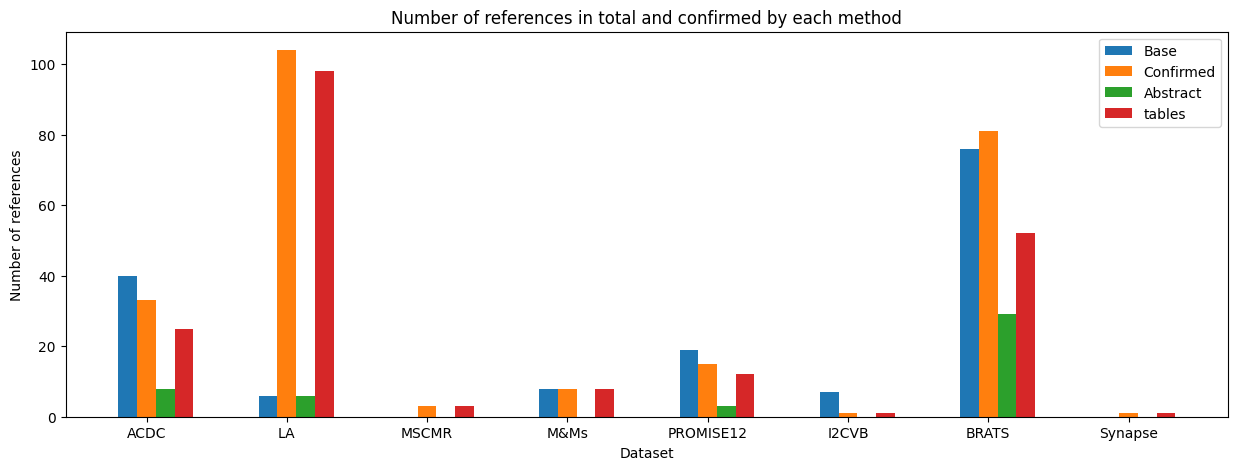

Base number of citation for ACDC: 40
Number of confirmed citations for ACDC: 33
Number of confirmed citations with abstract for ACDC: 8
Number of confirmed citations with tables for ACDC: 25

Base number of citation for LA: 6
Number of confirmed citations for LA: 104
Number of confirmed citations with abstract for LA: 6
Number of confirmed citations with tables for LA: 98

Base number of citation for MSCMR: 0
Number of confirmed citations for MSCMR: 3
Number of confirmed citations with abstract for MSCMR: 0
Number of confirmed citations with tables for MSCMR: 3

Base number of citation for M&Ms: 8
Number of confirmed citations for M&Ms: 8
Number of confirmed citations with abstract for M&Ms: 0
Number of confirmed citations with tables for M&Ms: 8

Base number of citation for PROMISE12: 19
Number of confirmed citations for PROMISE12: 15
Number of confirmed citations with abstract for PROMISE12: 3
Number of confirmed citations with tables for PROMISE12: 12

Base number of citation for I2

In [46]:
import matplotlib.pyplot as plt
X = list(paper_confirmed.keys())
nb_ref = [len(paper_referencing[x]) for x in X]
nb_confirmed = [len(paper_confirmed[x]) for x in X]
nb_abstract = [len(paper_using_abstract[x]) for x in X]
nb_tables = [len(paper_using_tables[x]) for x in X]

X_axis = np.arange(0,len(X)*3,3)

plt.figure(figsize=(15,5))
plt.bar(X_axis - 0.4, nb_ref, 0.4, label = 'Base')
plt.bar(X_axis, nb_confirmed, 0.4, label = 'Confirmed')
plt.bar(X_axis + 0.4, nb_abstract, 0.4, label = 'Abstract')
plt.bar(X_axis + 0.8, nb_tables, 0.4, label = 'tables')
  
plt.xticks(X_axis, X)
plt.xlabel("Dataset")
plt.ylabel("Number of references")
plt.title("Number of references in total and confirmed by each method")
plt.legend()
plt.show()

for d in paper_confirmed:
    print(f"Base number of citation for {d}: {len(paper_referencing[d])}")
    print(f"Number of confirmed citations for {d}: {len(paper_confirmed[d])}")
    print(f"Number of confirmed citations with abstract for {d}: {len(paper_using_abstract[d])}")
    print(f"Number of confirmed citations with tables for {d}: {len(paper_using_tables[d])}\n")